## Imports

In [60]:
import gzip, re, collections, statistics, math, lzma, tempfile, shutil
import zstandard as zstd
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from scipy.signal import butter, filtfilt, detrend

from sklearn.decomposition import FastICA
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score

from pyEDM import EmbedDimension
import tqdm.notebook as tqdm

In [2]:
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 24
plt.rcParams["figure.figsize"] = (12, 7)

SEED = 42

## Read Data

In [3]:
DATA_DIR = '../data/two-imu-one-dyn-syst/'
acc_1_df = pd.read_csv(DATA_DIR + 'acc-1.csv')
gyr_1_df = pd.read_csv(DATA_DIR + 'gyr-1.csv')

acc_2_df = pd.read_csv(DATA_DIR + 'acc-2.csv')
gyr_2_df = pd.read_csv(DATA_DIR + 'gyr-2.csv')

In [4]:
for df in (acc_1_df, gyr_1_df, acc_2_df, gyr_2_df):
    print(df.shape)
    print(df.head())

(38122, 5)
                  time  seconds_elapsed         z         y         x
0  1747571324974342100         0.078342 -0.012631 -0.002333  0.001062
1  1747571324990302500         0.094302 -0.036629 -0.025879 -0.015898
2  1747571325006293500         0.110293  0.025593  0.012618 -0.037439
3  1747571325022253800         0.126254 -0.065401  0.003188  0.009917
4  1747571325038244900         0.142245 -0.017526  0.008071 -0.009710
(38112, 5)
                  time  seconds_elapsed         z         y         x
0  1747571324967048400         0.071048  0.001222 -0.003054 -0.001222
1  1747571324982368300         0.086368  0.000611 -0.001222 -0.001222
2  1747571324998359000         0.102359 -0.002443 -0.000611 -0.001833
3  1747571325014319600         0.118320  0.001222 -0.003665  0.000611
4  1747571325030310400         0.134310  0.001222 -0.004276  0.000000
(60952, 5)
                  time  seconds_elapsed         z         y         x
0  1747571324508624600         0.121625  0.062182 -0.0004

Rename columns

In [5]:
acc_columns_mapping = {'x': 'acc_x', 'y': 'acc_y', 'z': 'acc_z'}
gyr_columns_mapping = {'x': 'gyr_x', 'y': 'gyr_y', 'z': 'gyr_z'}

acc_1_df.rename(columns=acc_columns_mapping, inplace=True)
gyr_1_df.rename(columns=gyr_columns_mapping, inplace=True)

acc_2_df.rename(columns=acc_columns_mapping, inplace=True)
gyr_2_df.rename(columns=gyr_columns_mapping, inplace=True)

Plot data

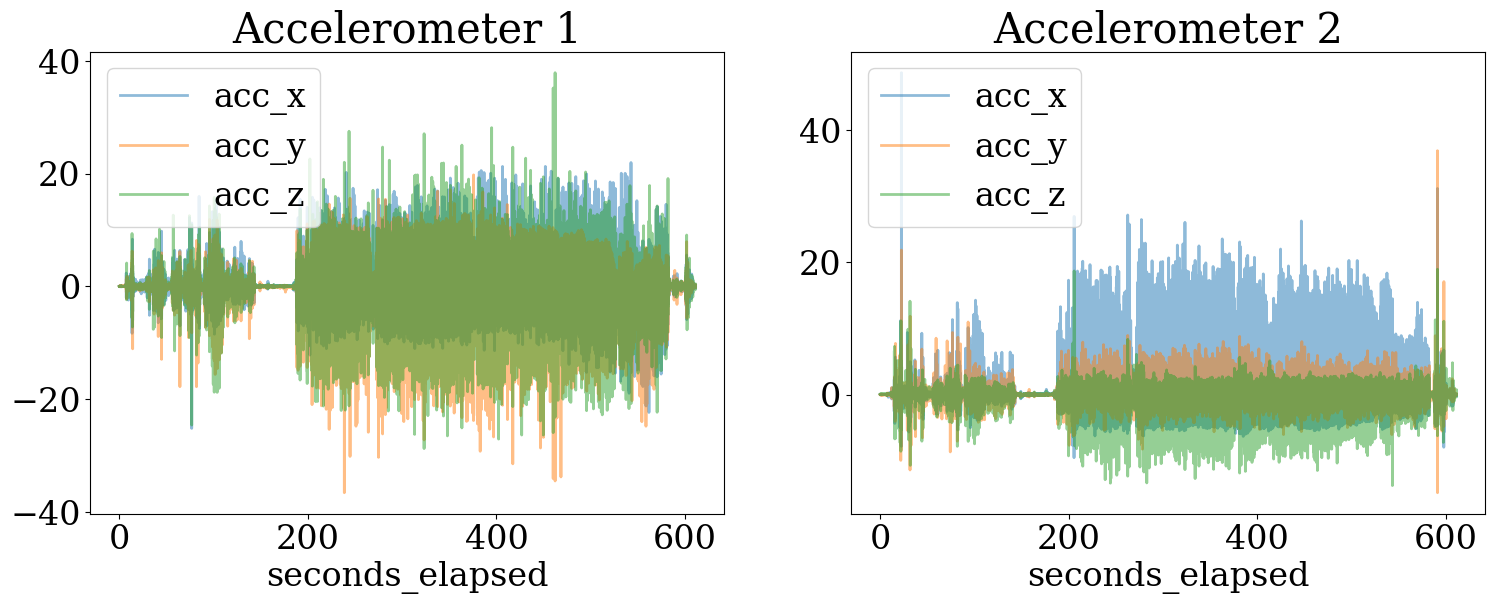

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

acc_1_df.plot(x='seconds_elapsed', y=list(acc_columns_mapping.values()), alpha=0.5, title='Accelerometer 1', ax=axes[0])
acc_2_df.plot(x='seconds_elapsed', y=list(acc_columns_mapping.values()), alpha=0.5, title='Accelerometer 2', ax=axes[1])
plt.show()

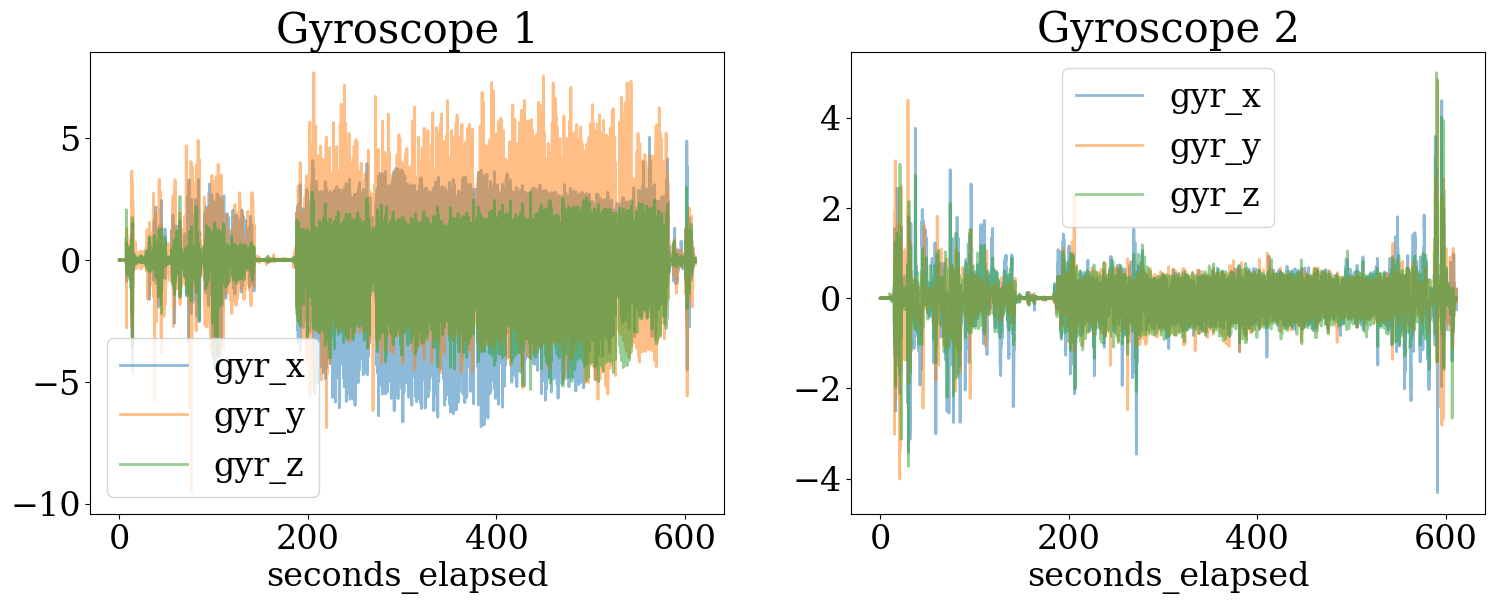

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

gyr_1_df.plot(x='seconds_elapsed', y=list(gyr_columns_mapping.values()), alpha=0.5, title='Gyroscope 1', ax=axes[0])
gyr_2_df.plot(x='seconds_elapsed', y=list(gyr_columns_mapping.values()), alpha=0.5, title='Gyroscope 2', ax=axes[1])
plt.show()

Join data from the same system

Note that tolerance is different because system 1 has a 60 Hz frequency while the system 2 has a 100 Hz frequency

0.017 $\approx 1/60$ 

In [8]:
eps = 1e3

df_1 = pd.merge_asof(acc_1_df, gyr_1_df, on='seconds_elapsed', direction='nearest', tolerance=1/60 + eps)
df_2 = pd.merge_asof(acc_2_df, gyr_2_df, on='seconds_elapsed', direction='nearest', tolerance=1/100 + eps)

In [9]:
assert len(df_1) == len(acc_1_df)
assert len(df_2) == len(acc_2_df)

In [10]:
print(df_1.shape)
df_1.head()

(38122, 9)


,time_x,seconds_elapsed,acc_z,acc_y,acc_x,time_y,gyr_z,gyr_y,gyr_x
0,1747571324974342100,0.078342,-0.012631,-0.002333,0.001062,1747571324967048400,0.001222,-0.003054,-0.001222
1,1747571324990302500,0.094302,-0.036629,-0.025879,-0.015898,1747571324982368300,0.000611,-0.001222,-0.001222
2,1747571325006293500,0.110293,0.025593,0.012618,-0.037439,1747571324998359000,-0.002443,-0.000611,-0.001833
3,1747571325022253800,0.126254,-0.065401,0.003188,0.009917,1747571325014319600,0.001222,-0.003665,0.000611
4,1747571325038244900,0.142245,-0.017526,0.008071,-0.009710,1747571325030310400,0.001222,-0.004276,0.000000


In [11]:
print(df_2.shape)
df_2.head()

(60952, 9)


,time_x,seconds_elapsed,acc_z,acc_y,acc_x,time_y,gyr_z,gyr_y,gyr_x
0,1747571324508624600,0.121625,0.062182,-0.000405,0.008137,1747571324508655000,-0.000533,0.001598,0.0
1,1747571324518604000,0.131604,0.057374,0.013954,0.001110,1747571324518634500,-0.000533,0.001598,0.0
2,1747571324528583200,0.141583,0.047779,0.016342,0.008448,1747571324528644000,-0.000533,0.001598,0.0
3,1747571324538562300,0.151562,0.047760,0.009153,-0.005762,1747571324538593000,-0.000533,0.001598,0.0
4,1747571324548541700,0.161542,0.062106,0.011541,0.011153,1747571324548602600,-0.000533,0.001598,0.0


In [12]:
df_1.drop(columns=['time_x', 'time_y'], inplace=True)
df_2.drop(columns=['time_x', 'time_y'], inplace=True)

Cut the data by time: drop first and last minute

In [16]:
min_t = 200
max_t = min(df_1.seconds_elapsed.max(), df_2.seconds_elapsed.max()) - 60

df_1 = df_1.query(f"{min_t} <= seconds_elapsed <= {max_t}").reset_index(drop=True)
df_2 = df_2.query(f"{min_t} <= seconds_elapsed <= {max_t}").reset_index(drop=True)

Align frequencies

In [17]:
df_merged = pd.concat(
    (df_1.assign(source=1), df_2.assign(source=2)),
    axis=0
)\
.reset_index(drop=True)\
.sort_values(by='seconds_elapsed', ignore_index=True)

df_merged.iloc[df_merged.query("source == 1").index, 1:-1] = None
df_merged = df_merged.set_index('seconds_elapsed')

In [18]:
df_interpolated = df_merged.interpolate(method='index')
df_2_interp = df_interpolated.query("source == 1").drop(columns='source').reset_index()

In [19]:
assert df_1.shape == df_2_interp.shape

Define time lag

In [20]:
acc_1 = df_1[list(acc_columns_mapping.values())].apply(np.square).sum(axis=1).apply(np.sqrt)
acc_2 = df_2_interp[list(acc_columns_mapping.values())].apply(np.square).sum(axis=1).apply(np.sqrt)

gyr_1 = df_1[list(gyr_columns_mapping.values())].apply(np.square).sum(axis=1).apply(np.sqrt)
gyr_2 = df_2_interp[list(gyr_columns_mapping.values())].apply(np.square).sum(axis=1).apply(np.sqrt)

In [21]:
def normalize(arr):
    return (arr - arr.mean()) / arr.std()


acc_1_norm = normalize(acc_1)
acc_2_norm = normalize(acc_2)

gyr_1_norm = normalize(gyr_1)
gyr_2_norm = normalize(gyr_2)

In [22]:
acc_corr = np.correlate(acc_1_norm, acc_2_norm, mode='full')
gyr_corr = np.correlate(gyr_1_norm, gyr_2_norm, mode='full')

In [23]:
acc_lag_idx = acc_corr.argmax() - (len(acc_1_norm) - 1)
gyr_lag_idx = gyr_corr.argmax() - (len(gyr_1_norm) - 1)

acc_lag_idx, gyr_lag_idx

(4, 14)

## Define causal dimension

Filter data, CCA with time lags, VAR

In [26]:
from scipy.signal import butter, filtfilt, detrend
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR

In [37]:
# 8. Permutation test for significance
perm_corrs = np.zeros((n_perm, cca_corrs.size))
for i in tqdm.tqdm(range(n_perm)):
    perm_idx = np.random.permutation(Xs.shape[0])
    Up, Vp = cca.fit_transform(Xs[perm_idx], Ys)
    perm_corrs[i] = [np.corrcoef(Up[:, j], Vp[:, j])[0,1] for j in range(U.shape[1])]

perm_thresholds = np.percentile(perm_corrs, 95, axis=0)

  0%|          | 0/100 [00:00<?, ?it/s]

In [35]:
K = 3
n_perm = 100
highpass_cutoff = 0.1

# 4. Extract arrays
X = df_1.iloc[..., 1:].values
Y = df_2_interp.iloc[..., 1:].values
n, p = X.shape
q = Y.shape[1]

dt = np.median(np.diff(df_1.seconds_elapsed.values))
fs = 1.0 / dt
b, a = butter(4, highpass_cutoff/(0.5*fs), btype='high')
for col in range(X.shape[1]):
    X[..., col] = filtfilt(b, a, detrend(X[..., col]))

for col in range(Y.shape[1]):
    Y[..., col] = filtfilt(b, a, detrend(Y[..., col]))
    
# 5. Build lagged design matrix for X
X_lag = np.hstack([np.roll(X, k, axis=0) for k in range(1, K+1)])[K:]
Y_trunc = Y[K:] # adjust time

# 6. Standardize
scaler_X = StandardScaler().fit(X_lag)
scaler_Y = StandardScaler().fit(Y_trunc)
Xs = scaler_X.transform(X_lag)
Ys = scaler_Y.transform(Y_trunc)

# 7. Canonical Correlation on lagged data
cca = CCA(n_components=min(p*K, q))
U, V = cca.fit_transform(Xs, Ys)
cca_corrs = np.array([np.corrcoef(U[:, i], V[:, i])[0,1] for i in range(U.shape[1])])

In [41]:
# 9. VAR reduced-rank estimate
df_var = pd.DataFrame(
    np.hstack([X[K:], Y[K:]]),
    columns=[f'X{j}' for j in range(p)] + [f'Y{j}' for j in range(q)],
)
df_var = pd.DataFrame(StandardScaler().fit_transform(df_var),
                      columns=df_var.columns, index=df_var.index)

model = VAR(df_var)
res   = model.fit(maxlags=K, ic=None)

# tablet columns come first → rows q: (phone), cols 0:p (tablet)
B_blocks = []
for kk, lag in enumerate([1, 2, 3], start=1):
    B_xy = res.coefs[lag-1][q:, :p]   # (q × p) block
    B_blocks.append(B_xy)
B_concat = np.hstack(B_blocks)
var_rank = np.linalg.matrix_rank(B_concat, tol=1e-6)

In [43]:
cca_corrs, perm_thresholds, var_rank

(array([0.36292029, 0.26012193, 0.15107524, 0.08716008, 0.05624983,
        0.02070081]),
 array([0.04662657, 0.03951384, 0.03399668, 0.02876058, 0.02443174,
        0.0199867 ]),
 6)

**Conclusion**: It's a bullshit

## Define causal dimension

EDM framework

In [46]:
# choose the axis you believe carries the shared vertical motion
TAB_AXIS  = 'acc_z'
PHN_AXIS  = 'acc_z'

# tablet
tab_edm = df_1[['seconds_elapsed', TAB_AXIS]].copy()
tab_edm.columns = ['Time', 'TabletZ']

# phone
phn_edm = df_2_interp[['seconds_elapsed', PHN_AXIS]].copy()
phn_edm.columns = ['Time', 'PhoneZ']

# merge into one data block so EmbedDimension can inspect both series
df_edm = tab_edm.merge(phn_edm, on='Time')

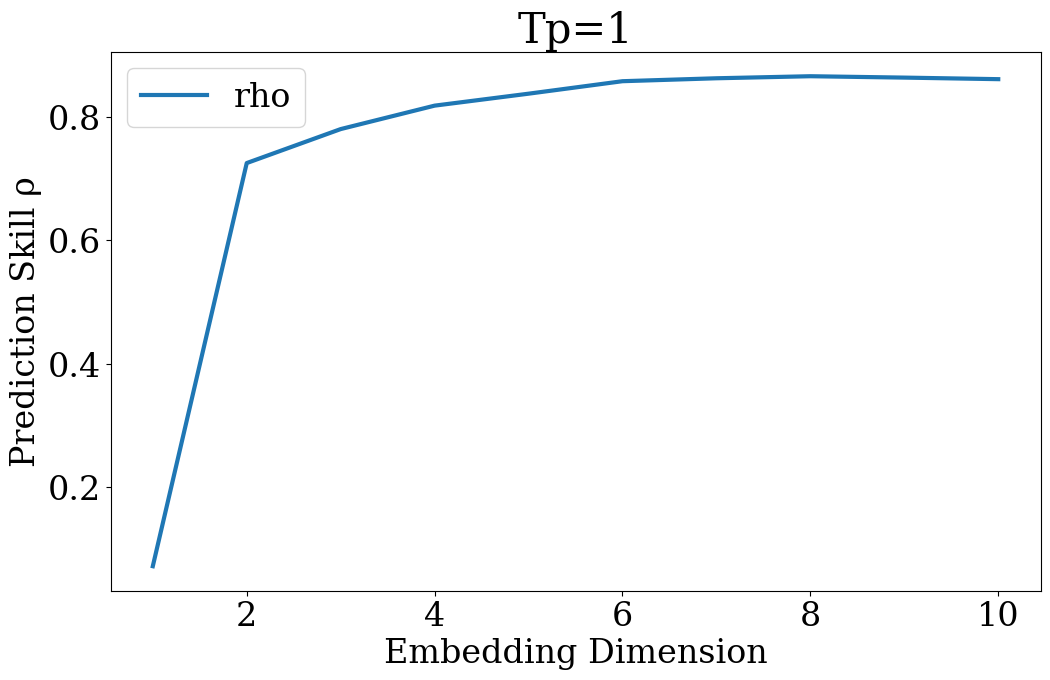

In [54]:
E_MAX = 10
LIB_END = int(0.6 * len(df_edm))        # 60 % for the “library”
PRED_BEG = LIB_END + 1

df_TT = EmbedDimension(dataFrame=df_edm,
                      columns='TabletZ',
                      target='TabletZ',
                      lib=f'1 {LIB_END}',
                      pred=f'{PRED_BEG} {len(df_edm)}',
                      maxE=E_MAX,
                      showPlot=True)    

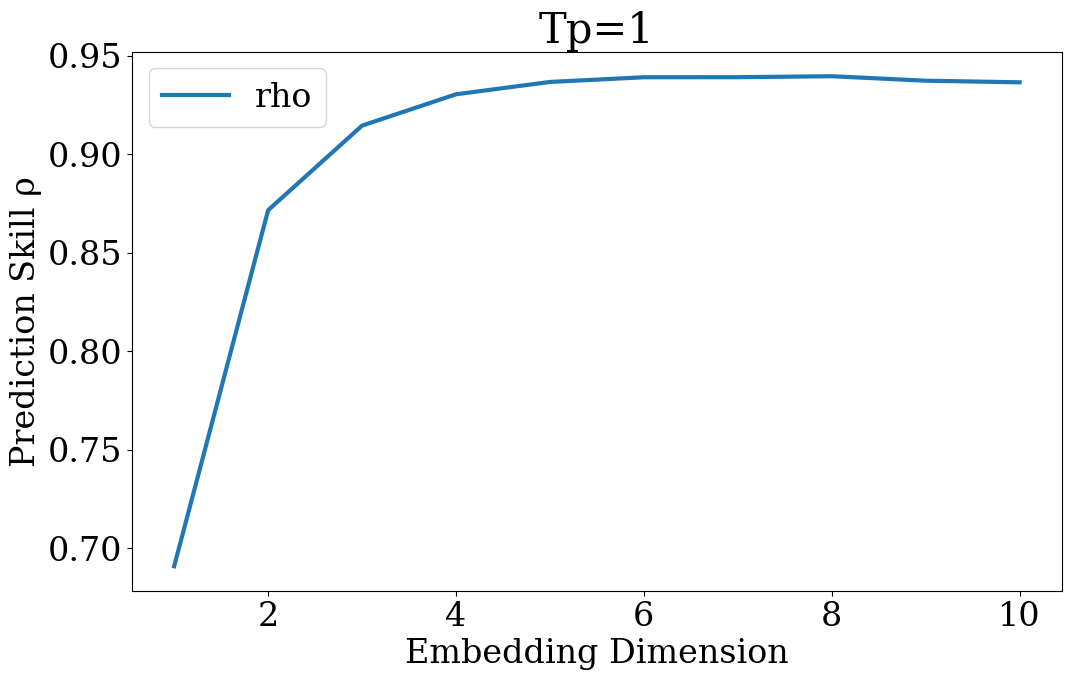

In [55]:
df_PP = EmbedDimension(dataFrame=df_edm,
                       columns='PhoneZ',
                       target='PhoneZ',
                       lib=f'1 {LIB_END}',
                       pred=f'{PRED_BEG} {len(df_edm)}',
                       maxE=E_MAX,
                       showPlot=True)

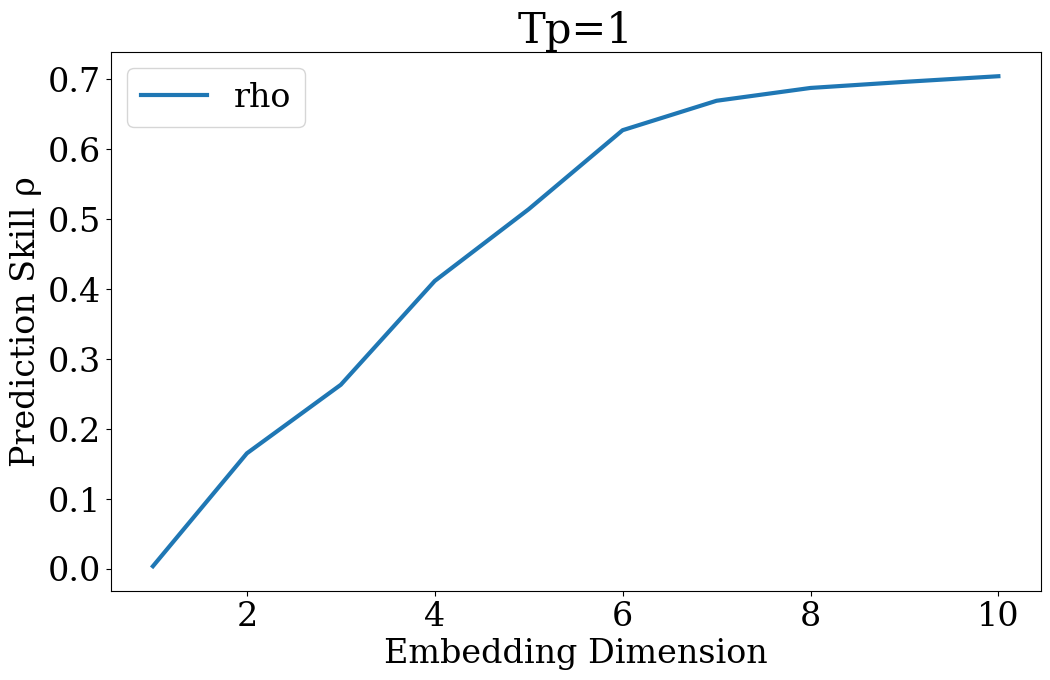

In [56]:
df_PT = EmbedDimension(dataFrame=df_edm,
                       columns='PhoneZ',
                       target='TabletZ',
                       lib=f'1 {LIB_END}',
                       pred=f'{PRED_BEG} {len(df_edm)}',
                       maxE=E_MAX,
                       showPlot=True)

In [57]:
df_TT, df_PP, df_PT

(    E       rho
 0   1  0.071675
 1   2  0.725563
 2   3  0.780666
 3   4  0.818696
 4   5  0.838082
 5   6  0.858332
 6   7  0.863084
 7   8  0.866408
 8   9  0.864160
 9  10  0.861634,
     E       rho
 0   1  0.690751
 1   2  0.871489
 2   3  0.914432
 3   4  0.930332
 4   5  0.936593
 5   6  0.938981
 6   7  0.939010
 7   8  0.939502
 8   9  0.937223
 9  10  0.936413,
     E       rho
 0   1  0.003410
 1   2  0.164967
 2   3  0.263101
 3   4  0.411661
 4   5  0.514333
 5   6  0.627420
 6   7  0.669538
 7   8  0.687882
 8   9  0.696594
 9  10  0.704666)

In [59]:
# ------------------------------------------------------------
# Hyper-parameters
# ------------------------------------------------------------
K              = 3        # number of causal lags
CAUSAL_DIM     = 1        # m_c  (fixed by you)
RECON_DIM      = 12       # m_r  (tunable)
HIGH_PASS_HZ   = 0.1
PRINT_MI       = True

# ------------------------------------------------------------
# 1.  Tablet = df_1  |  Phone = df_2_interp
# ------------------------------------------------------------
tab = df_1.copy()
phn = df_2_interp.copy()

# keep only numeric sensor columns
tab_X = tab.iloc[:, 1:].to_numpy(copy=True)   # (n × p)
phn_Y = phn.iloc[:, 1:].to_numpy(copy=True)   # (n × q)
p, q  = tab_X.shape[1], phn_Y.shape[1]

# high-pass to remove drift
dt = np.median(np.diff(tab.seconds_elapsed))
fs = 1.0 / dt
b, a = butter(4, HIGH_PASS_HZ / (0.5 * fs), btype="high")
for j in range(p):
    tab_X[:, j] = filtfilt(b, a, detrend(tab_X[:, j]))
for j in range(q):
    phn_Y[:, j] = filtfilt(b, a, detrend(phn_Y[:, j]))

# ------------------------------------------------------------
# 2.  build lagged-tablet block for causal learning
# ------------------------------------------------------------
lags   = range(1, K + 1)
X_lag  = np.hstack([np.roll(tab_X, k, axis=0) for k in lags])[K:]   # (n-K) × (pK)
Y_curr = phn_Y[K:]                                                  # align

Xs = StandardScaler().fit_transform(X_lag)
Ys = StandardScaler().fit_transform(Y_curr)

# ------------------------------------------------------------
# 3.  Reduced-rank regression (rank 1)
# ------------------------------------------------------------
cca = CCA(n_components=CAUSAL_DIM, max_iter=2000)
Z_c, _ = cca.fit_transform(Xs, Ys)          # Z_c is (n-K) × 1  ← causal latent
Z_c    = Z_c.ravel()                        # (n-K,)

# regression: phone ≈ Z_c * beta
beta_phone = np.linalg.lstsq(Z_c[:, None], Ys, rcond=None)[0]       # (1 × q)
Y_hat_c    = Z_c[:, None] @ beta_phone
r2_phone   = r2_score(Ys, Y_hat_c, multioutput="variance_weighted")

# ------------------------------------------------------------
# 4.  Remove causal projection from tablet → reconstructive PCA
# ------------------------------------------------------------
# project X onto the causal axis in the original (pK) space
A = cca.x_weights_[:, 0]                    # (pK,) canonical vector
A /= np.linalg.norm(A)

proj = (Xs @ A)[:, None] * A[None, :]
X_resid = Xs - proj                         # causal component removed

pca = PCA(n_components=RECON_DIM)
Z_r   = pca.fit_transform(X_resid)          # (n-K × m_r)
X_hat_r = pca.inverse_transform(Z_r)        # reconstruction of residual part

# ------------------------------------------------------------
# 5.  Full reconstruction of the tablet signal
# ------------------------------------------------------------
X_hat_full = proj + X_hat_r                 # still in standardised units
rmse_tab   = np.sqrt(np.mean((Xs - X_hat_full) ** 2))

print(f"Phone R² explained by causal latent       : {r2_phone:.3f}")
print(f"Tablet RMSE with causal+recon latents      : {rmse_tab:.3f}")

# ------------------------------------------------------------
# 6.  Mutual information check (optional)
# ------------------------------------------------------------
if PRINT_MI:
    z_feat = Z_c.reshape(-1, 1)            # (n-K, 1)  as "features"

    mi = np.empty(q)                       # will store one value per phone axis
    for j in range(q):
        # target must be 1-D → take column j of Ys
        mi[j] = mutual_info_regression(z_feat,
                                       Ys[:, j],   # target
                                       random_state=0)[0]

    print("Mutual information (Z_c → each phone dim):",
          np.round(mi, 3))

Phone R² explained by causal latent       : 0.018
Tablet RMSE with causal+recon latents      : 0.183
Mutual information (Z_c → each phone dim): [0.101 0.071 0.166 0.052 0.068 0.044]
